В качестве моделей выберем модели с библиотеки CatBoost. Задачу классификации будет решать CatBoostClassifier, задачу регрессии - CatBoostRegressor

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


Импортируем библиотеки

In [3]:
import pandas as pd
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split

Считаем файл

In [4]:
df = pd.read_csv('train_dataset_train.csv')
df.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


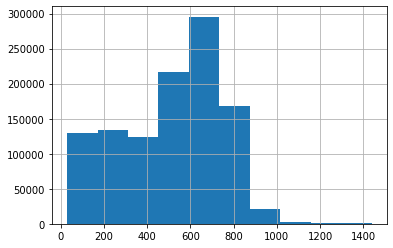

In [9]:
df['time_to_under'].hist()

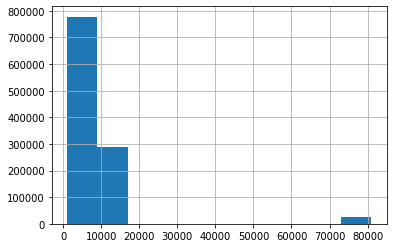

In [10]:
df['label'].hist(bins=10)

Рассмотрим его подробнее, а именно размер, число уникальных значений и скажем о смысле каждой колонки

In [12]:
df.describe(include='all')

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
count,1.091021e+06,1091021,1091021,1.091021e+06,1091021,1.091021e+06,1091021,1.091021e+06,1091021,1091021,1.091021e+06,1.091021e+06
unique,NaN,335533,60,NaN,426,NaN,245,NaN,16,297040,NaN,NaN
top,NaN,7992E92F9AE0F7506BD439547FD7E11F,КОШЕЛЕК,NaN,Щёлковская ( Северный ),NaN,Щёлковская,NaN,Таганско-Краснопресненская,2022-09-12 08:20:09,NaN,NaN
freq,NaN,8,262499,NaN,17810,NaN,22133,NaN,156031,29,NaN,NaN
mean,5.455110e+05,NaN,NaN,8.581884e+02,NaN,8.601452e+03,NaN,8.590013e+00,NaN,NaN,5.104668e+02,7.723527e+03
std,3.149508e+05,NaN,NaN,9.003577e+02,NaN,1.247133e+04,NaN,1.247157e+01,NaN,NaN,2.328452e+02,1.167015e+04
min,1.000000e+00,NaN,NaN,2.000000e+01,NaN,1.002000e+03,NaN,1.000000e+00,NaN,NaN,3.001667e+01,1.002000e+03
25%,2.727560e+05,NaN,NaN,2.150000e+02,NaN,3.018000e+03,NaN,3.000000e+00,NaN,NaN,3.229500e+02,3.006000e+03
50%,5.455110e+05,NaN,NaN,3.370000e+02,NaN,7.009000e+03,NaN,7.000000e+00,NaN,NaN,5.686833e+02,6.013000e+03
75%,8.182660e+05,NaN,NaN,2.087000e+03,NaN,9.022000e+03,NaN,9.000000e+00,NaN,NaN,6.838833e+02,9.012000e+03


Для станции, входа в неё и ветки есть дублирующие колонки, а именно id и название. Удалим id этих параметров. Также удалим колонку id. 

In [13]:
df.drop(columns=['entrance_id','station_id','line_id','id'],inplace=True)

Глянем на пропуски и удалим если они есть

In [14]:
df.isnull().sum()

ticket_id         0
ticket_type_nm    0
entrance_nm       0
station_nm        0
line_nm           0
pass_dttm         0
time_to_under     0
label             0
dtype: int64

Так как id билета для каждого пользователя уникален, то нет смысла его оставлять в обучающей выборки - удалим его.

In [15]:
df.drop(columns=['ticket_id'], inplace=True)

Перейдём к решению. Начнём с регрессии: чтобы модель могла делать прогноз обработаем параметр дата валидации: извлечём день недели,час и параметр рабочий день/выходной. Месяц не трогаем, тк данные представлена за неделю. Все остальные признаки будут категориальными для модели CatBoost

In [16]:
def time_preprocess_r(df):
    df['day'] = df.pass_dttm.dt.dayofweek #день недели
    df['hour'] = df.pass_dttm.dt.hour # час в формате 24
    df['workday'] = df['day'].apply(lambda x: 0 if x == 5 or x == 6 else 1)
    df = df.drop(columns=['pass_dttm'])
    return df

In [17]:
df.pass_dttm = pd.to_datetime(df.pass_dttm)

x_regress_train, x_regress_test, y_regress_train, y_regress_test = train_test_split(df.drop(columns=['time_to_under']), df[['time_to_under']], test_size=0.3)
x_regress_train = time_preprocess_r(x_regress_train)
x_regress_test = time_preprocess_r(x_regress_test)


model_regression = CatBoostRegressor(iterations = 10)
model_regression.fit(x_regress_train,y_regress_train, cat_features=['ticket_type_nm','entrance_nm','station_nm','line_nm'])
forecast_regression=model_regression.predict(x_regress_test)

Learning rate set to 0.5
0:	learn: 186.9152947	total: 390ms	remaining: 3.51s
1:	learn: 169.2564073	total: 676ms	remaining: 2.7s
2:	learn: 164.1337710	total: 936ms	remaining: 2.18s
3:	learn: 162.3125088	total: 1.25s	remaining: 1.88s
4:	learn: 161.6241261	total: 1.54s	remaining: 1.54s
5:	learn: 161.3624843	total: 1.8s	remaining: 1.2s
6:	learn: 161.0179657	total: 2.05s	remaining: 879ms
7:	learn: 160.8814853	total: 2.32s	remaining: 579ms
8:	learn: 160.5939880	total: 2.58s	remaining: 287ms
9:	learn: 160.4777901	total: 2.85s	remaining: 0us


Рассмотрим классификацию: категориальные признаки все те же. Дату валидации также преобразуем, но уже с учётом, того что модель классификации а не регрессии.

In [18]:
def time_preprocess_c(df):
    df['day'] = df.pass_dttm.dt.dayofweek #день недели
    df['hour'] = df.pass_dttm.dt.hour # час в формате 24
    df['workday'] = df['day'].apply(lambda x: 0 if x == 5 or x == 6 else 1)

    df['name_workday'] = df['day'].apply(lambda x : 'holiday' if x == 5 or x ==6  else 'work')

    df = df.drop(columns=['pass_dttm','day','hour','workday'])
    return df

В силу огр-ти выч ресурсов обрежем данные

In [19]:
df.pass_dttm = pd.to_datetime(df.pass_dttm)

x_class_train = df.drop(columns=['label'])[:500]
y_class_train = df[['label']][:500]


test_class = df.loc[df.ticket_type_nm.isin(x_class_train.ticket_type_nm)&
                    df.entrance_nm.isin(x_class_train.entrance_nm) &
                    df.station_nm.isin(x_class_train.station_nm) &
                    df.line_nm.isin(x_class_train.line_nm) ]

x_class_test = test_class.drop(columns=['label'])[-100:]
y_class_test = test_class[['label']][-100:]

x_class_train = time_preprocess_c(x_class_train)
x_class_test = time_preprocess_c(x_class_test)


model_class = CatBoostClassifier(iterations = 10, depth = 5)
model_class.fit(x_class_train,y_class_train, cat_features=['name_workday','ticket_type_nm','entrance_nm','station_nm','line_nm'])
forecast_class= model_class.predict(x_class_test)


Learning rate set to 0.5
0:	learn: 5.0657173	total: 3.87s	remaining: 34.8s
1:	learn: 4.9025190	total: 7.65s	remaining: 30.6s
2:	learn: 4.7528377	total: 11.4s	remaining: 26.7s
3:	learn: 4.6548199	total: 15.2s	remaining: 22.8s
4:	learn: 4.5063368	total: 19s	remaining: 19s
5:	learn: 4.4186711	total: 20.6s	remaining: 13.8s
6:	learn: 4.2990402	total: 25.3s	remaining: 10.8s
7:	learn: 4.2449034	total: 29.2s	remaining: 7.31s
8:	learn: 4.1202723	total: 33s	remaining: 3.67s
9:	learn: 3.9893412	total: 36.9s	remaining: 0us


Проверим точность

In [20]:
from sklearn.metrics import r2_score, recall_score
def result(actual_class, forecast_class, actual_regress, forecast_regress):
    return 0.5 * r2_score(actual_regress, forecast_regress) + 0.5 * recall_score(actual_class, forecast_class, average='micro')


In [21]:
print('result: ', result(y_class_test, forecast_class, y_regress_test, forecast_regression))

result:  0.2633861734558882
